Esse código foi feito para aplicar o algoritmo de random forest para realizar uma previsão momentânea do valor
 de Potência gerada e comparar o resultado com o valor obtido por meio do modelo de equação única, ou também conhecido como modelo físico
 

# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

from Functions import import_PV_WT_data, ExpandSOLETE, TimePeriods, PrepareMLmodel, TestMLmodel, get_results, post_process

import datetime
import joblib


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Masking
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.models import load_model

#importando e definindo a função necessária para calcular r²
from scipy import stats
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

# Lendo os dados previamente limpos pelo arquivo "ExtraindoDadosSolete.ipynb"

In [2]:
#Importando os dados já limpos e trabalhados (sem falhas)
DATA=pd.read_csv('Data/Solete/ResampleHoraSemFalha.csv',index_col = 0, parse_dates=True)
PVinfo, WTinfo = import_PV_WT_data()
DATA.head()

,TEMPERATURE[degC],HUMIDITY[%],WIND_SPEED[m1s],WIND_DIR[deg],GHI[kW1m2],POA Irr[kW1m2],P_Gaia[kW],P_Solar[kW],Pressure[mbar],PR_A,Pac,Pdc,TempModule,TempCell
2018-06-01 04:00:00,14.956095,0.700000,1.252238,90.303333,0.137325,0.056974,0.000671,0.316833,1016.824675,0.771259,0.432287,0.440659,16.430217,16.601139
2018-06-01 05:00:00,16.359278,0.700000,1.571111,99.760833,0.225724,0.074395,0.056381,0.457303,1016.921153,0.851619,0.559628,0.570467,18.238640,18.461825
2018-06-01 06:00:00,18.266389,0.633500,1.654250,101.448611,0.344626,0.143629,0.034202,0.981629,1016.602885,0.959274,1.058032,1.078524,21.879632,22.310520
2018-06-01 07:00:00,20.064750,0.587972,1.555750,99.841944,0.451299,0.342008,0.002903,2.350645,1016.332812,0.954127,2.435991,2.483171,28.717007,29.743032
2018-06-01 08:00:00,21.713278,0.499583,1.627639,106.434167,0.540191,0.538267,0.003948,3.661579,1016.145600,0.945578,3.704321,3.776067,35.266054,36.880854


## Visualisando os dados

In [3]:
P = "P_Solar[kW]"
IRR = "POA Irr[kW1m2]"

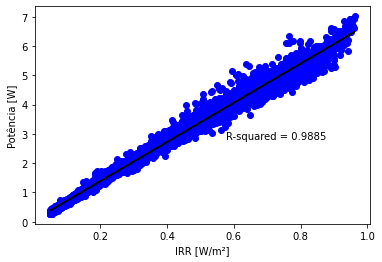

R-square =  0.9885398006396707


In [4]:
#Plotando um gráfico scatter de todos os dias com uma fit line e o R²
plt.scatter(DATA[IRR],DATA[P], color = "blue")
plt.xlabel("IRR [W/m²]")
plt.ylabel("Potência [W]")

a, b = np.polyfit(DATA[IRR],DATA[P], 1) #Encontrando a melhor fit line (R²) entre os dois valores
plt.plot(DATA[IRR], a*DATA[IRR]+b, color = "black",)
r2 = rsquared(DATA[IRR],DATA[P])
plt.text(0.6*DATA[IRR].max(), 0.4*DATA[P].max(), 'R-squared = %0.4f' % r2, color = "black")
plt.show()

print("R-square = ", r2)

# Aplicando Machine Learning na faixa global de irradiância

## Separando em variaveis de X e Y (possible features and features to be predicted)

In [33]:
df2 = DATA.copy()
X = df2[['TEMPERATURE[degC]', 'HUMIDITY[%]', 'POA Irr[kW1m2]', 'Pac', 'TempModule', 'TempCell', 'GHI[kW1m2]']]
y = df2[['P_Solar[kW]']]

In [34]:
# Separando as variáveis de treinamento e teste
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=21,shuffle=False)

## Treinando com RandomForest (RF)

In [35]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test) * 100, 2)

print("R2 Score : ",R2_Score_rfr,"%")

C:\Users\Bruno\AppData\Local\Temp\ipykernel_1216\2455175296.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train,y_train)


R2 Score :  98.77 %


In [37]:
PredictionGlobal = rfr.predict(X_test)
print(type(PredictionGlobal))
print(PredictionGlobal)
df_predictGlobal = pd.DataFrame(PredictionGlobal, columns = ["P_Solar[kW]"], index = y_test.index)

<class 'numpy.ndarray'>
[2.7757466  4.05001606 4.78906976 ... 2.63190607 1.25727402 0.42097121]


In [9]:
print("Tamanho da predição",df_predictGlobal.shape[0],"Tamanho do y_teste",y_test.shape[0])
print("Tamanho total",df2.shape[0],"Tamanho do y_train",y_train.shape[0])

Tamanho da predição 1406 Tamanho do y_teste 1406
Tamanho total 4685 Tamanho do y_train 3279


## Calculando o RMSE do valor obtido pelo RF

In [10]:
from sklearn.metrics import mean_squared_error

In [12]:
RMSE_RF = mean_squared_error(y_test, df_predictGlobal) * 100
RMSE_RF

3.4305651509206703

## RMSE pelo modelo físico

In [36]:
RMSE_MF = mean_squared_error(y_test, X_test['Pac']) * 100
Pac_Faixa_Global = X_test # Adquirindo o valor de Pac dos dados utilizados para teste para salvar junto com os resultados
RMSE_MF

4.9896600028676925

# Aplicando Machine Learning nas três faixas separadas de irradiância

In [14]:
# Separando as três faixas
selecao_faixa1 = (df2[IRR] >= 50/1000) & (df2[IRR] <= 250/1000)
selecao_faixa2 = (df2[IRR] > 250/1000) & (df2[IRR] <= 500/1000)
selecao_faixa3 = (df2[IRR] > 500/1000)

df2_faixa1 = df2[selecao_faixa1]
df2_faixa2 = df2[selecao_faixa2]
df2_faixa3 = df2[selecao_faixa3]

## Treinando RF para cada faixa

### Faixa 1 (50-250)

In [15]:
X = df2_faixa1[['TEMPERATURE[degC]', 'HUMIDITY[%]', 'POA Irr[kW1m2]', 'Pac', 'TempModule', 'TempCell', 'GHI[kW1m2]']]
y = df2_faixa1[['P_Solar[kW]']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=21,shuffle=False)

In [16]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test) * 100, 2)


C:\Users\Bruno\AppData\Local\Temp\ipykernel_1216\3050978266.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train,y_train)


In [17]:
PredictionFaixa1 = y_pred_rfr
print(type(PredictionFaixa1))
df_predictFaixa1 = pd.DataFrame(PredictionFaixa1, columns = ["P_Solar[kW]"], index = y_test.index)

<class 'numpy.ndarray'>
[0.67591017 0.5619549  0.57986154 0.45589414 0.83750453 1.64525643
 1.52220456 0.71030036 0.44550334 0.40965837 0.94326494 0.86610704
 0.68124738 1.44457107 0.79110891 1.5371676  1.05115643 1.04117626
 1.69095076 0.45984934 0.36864843 0.32543358 0.50499209 0.48052971
 0.5541011  0.59752968 0.59522854 0.78706346 0.66318521 0.4650597
 0.38958504 0.34623327 0.36503537 0.6016674  1.19017232 1.39807937
 0.7106626  0.40152285 0.31969379 0.39531579 0.95095379 1.06249593
 0.68736523 0.5496387  0.55472855 1.25728732 1.21571512 0.66180492
 0.4125035  0.54195027 0.96021849 1.73119833 1.44693811 0.49168842
 0.58046516 0.3260201  0.4993408  0.55816556 0.96236659 1.21262789
 1.28459428 0.56975948 0.44740208 0.83455329 1.08886312 1.38513067
 1.64075165 1.77276509 1.26764455 0.65669323 0.42911338 0.35150752
 0.65782798 1.63588891 1.85233151 1.68701801 0.55720441 0.32936978
 0.44024114 1.17157714 0.95058658 0.70597142 0.30141908 0.3769341
 0.66838231 0.45052216 0.85411107 0.8665

In [18]:
RMSE_RF_faixa1 = mean_squared_error(y_test, df_predictFaixa1) * 100
RMSE_RF_faixa1

0.417119335458676

In [19]:
RMSE_MF_faixa1 = mean_squared_error(y_test, X_test['Pac']) * 100
RMSE_MF_faixa1

1.1755901574932421

### Faixa 2 (250-500)

In [20]:
X = df2_faixa2[['TEMPERATURE[degC]', 'HUMIDITY[%]', 'POA Irr[kW1m2]', 'Pac', 'TempModule', 'TempCell', 'GHI[kW1m2]']]
y = df2_faixa2[['P_Solar[kW]']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=21,shuffle=False)

In [21]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test) * 100, 2)

C:\Users\Bruno\AppData\Local\Temp\ipykernel_1216\1857572404.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train,y_train)


In [22]:
PredictionFaixa2 = y_pred_rfr
print(type(PredictionFaixa2))
df_predictFaixa2 = pd.DataFrame(PredictionFaixa2, columns = ["P_Solar[kW]"], index = y_test.index)

<class 'numpy.ndarray'>
[1.96318917 3.23265626 2.38297198 2.97802097 2.79885804 2.23223858
 2.82835052 1.96085004 2.25940036 2.67818455 3.02703878 2.42350921
 3.20302078 1.91332988 3.13832927 1.97978609 2.11506606 2.36845193
 3.34132753 2.32472984 2.81126624 2.32552555 3.41029114 1.95781471
 2.44374576 2.01223726 1.98096274 3.0128509  2.56222302 3.34305143
 3.07495872 2.17580966 3.49120917 2.21961274 2.21785784 2.47681347
 2.00230034 1.95510495 2.20668091 1.97637175 2.64203651 3.05220518
 2.26794126 2.42590847 2.22815845 2.22934669 2.65025632 2.17601926
 2.25635948 2.80653033 3.36924674 2.75836203 2.23093788 2.28017597
 3.03673247 2.17922551 2.1892     3.4371929  2.27587067 3.18697295
 2.63639305 3.42223332 1.97464623 1.99515951 2.80445035 2.56399768
 2.21467199 3.35816797 3.36784593 3.17005867 2.21851682 3.24107823
 2.1980241  3.37933176 2.0486509  3.41193104 2.73107465 1.87706569
 2.07699047 2.83256438 2.14262973 2.2164544  2.10121019 3.34444833
 3.37439134 2.26850156 3.30920796 2.14

In [23]:
RMSE_RF_faixa2 = mean_squared_error(y_test, df_predictFaixa2) * 100
RMSE_RF_faixa2

3.173083626730323

In [24]:
RMSE_MF_faixa2 = mean_squared_error(y_test, X_test['Pac']) * 100
RMSE_MF_faixa2

3.9233826725654146

### Faixa 3 (500+)

In [25]:
X = df2_faixa3[['TEMPERATURE[degC]', 'HUMIDITY[%]', 'POA Irr[kW1m2]', 'Pac', 'TempModule', 'TempCell', 'GHI[kW1m2]']]
y = df2_faixa3[['P_Solar[kW]']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=21,shuffle=False)

In [26]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)
R2_Score_rfr = round(r2_score(y_pred_rfr,y_test) * 100, 2)

C:\Users\Bruno\AppData\Local\Temp\ipykernel_1216\1857572404.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train,y_train)


In [27]:
PredictionFaixa3 = y_pred_rfr
print(type(PredictionFaixa3))
df_predictFaixa3 = pd.DataFrame(PredictionFaixa3, columns = ["P_Solar[kW]"], index = y_test.index)

<class 'numpy.ndarray'>
[5.06370859 5.81170765 6.29462398 5.39982692 4.00002761 5.22731622
 5.92484884 5.94472836 4.35906864 3.96182452 4.80242079 5.41598788
 5.32492731 5.92670724 5.44136642 3.96964981 4.92791671 5.29117263
 5.65214603 5.57590346 4.399892   4.10313346 5.23030069 5.27074831
 3.65984213 4.53266882 4.39705625 4.37011513 3.94515608 4.08595585
 4.8025694  5.60997026 5.1617256  5.10502296 4.10328752 3.97418759
 5.08490518 5.67192097 5.8867402  5.88984578 5.06393996 3.74890058
 3.6402995  3.6740198  3.95096052 4.86242836 5.33206179 4.40700501
 4.35372619 3.71714562 3.89280057 4.78626579 5.0879231  5.23107121
 5.3171713  4.65411258 5.17345643 5.29679457 5.34534275 5.34126157
 4.3703368  4.15396181 4.18252992 4.78474994 5.55334971 4.28913676
 3.61875245 3.62775238 4.68948525 3.66356261 5.6025061  3.50432924
 3.51635357 4.52745774 5.23625253 5.40119955 5.27235277 4.73805187
 3.97950031 3.63444302 4.43567083 5.20428961 5.65008512 5.59225319
 5.07327119 4.15728784 3.74938174 4.31

In [28]:
RMSE_RF_faixa3 = mean_squared_error(y_test, df_predictFaixa3) * 100
RMSE_RF_faixa3

10.125924418221242

In [29]:
RMSE_MF_faixa3 = mean_squared_error(y_test, X_test['Pac']) * 100
RMSE_MF_faixa3

13.490149136805304

# Visualizando os resultados

In [30]:
data2 = ((RMSE_RF, RMSE_MF),
        (RMSE_RF_faixa1, RMSE_MF_faixa1),
        (RMSE_RF_faixa2, RMSE_MF_faixa2),
        (RMSE_RF_faixa3, RMSE_MF_faixa3)
)

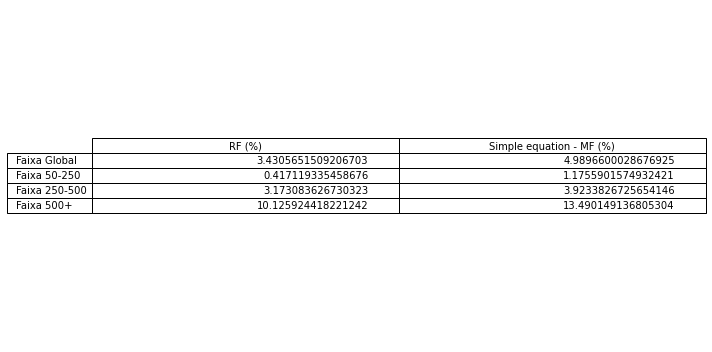

In [31]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
fig, axs = plt.subplots(1, 1)
columns = ('RF (%)', 'Simple equation - MF (%)')
rows = ['Faixa Global', 'Faixa 50-250','Faixa 250-500', 'Faixa 500+']
axs.axis('tight')
axs.axis('off')
the_table = axs.table(loc='center',cellText = data2, colLabels=columns,rowLabels= rows)
plt.show()

# Salvando os resultados em um dataframe

In [32]:
result = pd.DataFrame(index = df_predictGlobal.index) 
result['RF_Global'] = df_predictGlobal['P_Solar[kW]']
result['RF_Faixa1'] = df_predictFaixa1['P_Solar[kW]']
result['RF_Faixa2'] = df_predictFaixa2['P_Solar[kW]']
result['RF_Faixa3'] = df_predictFaixa3['P_Solar[kW]']
result['MF_Pac_Global'] = Pac_Faixa_Global['Pac']

result.to_csv('Data/Solete/RF_Result.csv')